# Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import seaborn as sns

# Reading Data

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Preprocessing Data

In [3]:
#Separating Labels and Features

y_train = train['label']
x_train = train.drop(['label'], axis = 1)
y_test = test['label']
x_test = test.drop(['label'], axis = 1)

y_train.value_counts() 

9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
Name: label, dtype: int64

In [4]:
#Converting DataFrame to Tensor

train_x = torch.tensor(x_train.values.astype(np.float32)) 
train_y = torch.tensor(y_train.values.astype(np.int64))
train_x[0], train_y[0]

(tensor([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   4.,   0.,   0.,   0.,   0.,   0.,  62.,  61.,
          21.,  29.,  23.,  51., 136.,  61.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  88.,
         201., 228., 225., 255., 115.,  62., 137., 255., 235., 222., 255., 135.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,  47., 252., 2

In [5]:
test_x = torch.tensor(x_test.values.astype(np.float32))
test_y = torch.tensor(y_test.values.astype(np.int64))

# Importing the Data into DataLoader

In [6]:
#Combining labels and feature tensor to prepare for DataLoader Function 

class mydataset(Dataset):
    def __init__(self, data, labels):
        self.labels = labels
        self.data = data
    def __len__(self):
        return len(self.labels)
    def __getitem__(self,i):
        item = self.data[i]
        label = self.labels[i]
        return (item,label)
    
training_data = mydataset(train_x,train_y)
testing_data = mydataset(test_x,test_y)

In [7]:
#Dividing the data into small batches

train_dataloader = DataLoader(training_data, batch_size = 100, shuffle = True)
test_dataloader = DataLoader(testing_data, batch_size = 100, shuffle = True)

# Model

In [8]:
class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.sequence = nn.Sequential(
            nn.Linear(784,100),
            nn.BatchNorm1d(num_features = 100), # normalize inputs across all the batches
            nn.ReLU(),
            nn.Dropout(0.4), #DropOut minimise the overfitting on training set
            nn.Linear(100,64),
            nn.BatchNorm1d(num_features = 64),
            nn.ReLU(),
            nn.Linear(64,28),
            nn.BatchNorm1d(num_features = 28),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(28,10),
            nn.ReLU()
        )
    def forward(self,x):
        output = self.sequence(x)
        return output


# Hyper-Parameters

In [9]:
model = NN()
loss_fn = nn.CrossEntropyLoss()
epochs = 100
lr_rate = .005

optimiser = torch.optim.Adam(model.parameters(),lr = lr_rate)

# Training The Model

In [10]:
def train_loop(dataloader, model, loss_fn, optimiser):
    size = len(dataloader.dataset)
    train_loss, correct = 0.0, 0
    for X, y in dataloader:
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item() # Adding loss across all batches
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        correct += ((nn.functional.softmax(pred, dim = 1)).argmax(1) == y).type(torch.float).sum().item()
        #Adding Accuracy across all batches
        
    train_loss /= size #mean of loss
    correct /= size  #mean of accuracy     
    print(f"Train Loss: {train_loss:.3f}")
    print(f"Train Accuracy: {correct:.3f}")
    return train_loss
    
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += ((nn.functional.softmax(pred, dim = 1)).argmax(1) == y).type(torch.float).sum().item()
            
    test_loss /= size
    correct /= size
    print(f"Test Loss: {test_loss:.3f}")
    print(f"Test Accuracy: {correct:.3f}")
    return test_loss

In [11]:
total_train_loss = []
total_test_loss = []

for t in range(epochs):
    print(f"[=================== Epoch: {t} ==================]")
    train_los = train_loop(train_dataloader, model, loss_fn, optimiser)
    total_train_loss.append(train_los)
    print('')
    test_los = test_loop(test_dataloader, model, loss_fn)
    total_test_loss.append(test_los)

[=================== Epoch: 0 ==================]
Train Loss: 0.007
Train Accuracy: 0.754

Test Loss: 0.006
Test Accuracy: 0.804
[=================== Epoch: 1 ==================]
Train Loss: 0.006
Train Accuracy: 0.813

Test Loss: 0.005
Test Accuracy: 0.821
[=================== Epoch: 2 ==================]
Train Loss: 0.005
Train Accuracy: 0.828

Test Loss: 0.005
Test Accuracy: 0.829
[=================== Epoch: 3 ==================]
Train Loss: 0.005
Train Accuracy: 0.835

Test Loss: 0.005
Test Accuracy: 0.837
[=================== Epoch: 4 ==================]
Train Loss: 0.005
Train Accuracy: 0.842

Test Loss: 0.005
Test Accuracy: 0.840
[=================== Epoch: 5 ==================]
Train Loss: 0.005
Train Accuracy: 0.845

Test Loss: 0.005
Test Accuracy: 0.844
[=================== Epoch: 6 ==================]
Train Loss: 0.004
Train Accuracy: 0.847

Test Loss: 0.005
Test Accuracy: 0.847
[=================== Epoch: 7 ==================]
Train Loss: 0.004
Train Accuracy: 0.850

Test L

Train Loss: 0.003
Train Accuracy: 0.891

Test Loss: 0.004
Test Accuracy: 0.866
[=================== Epoch: 64 ==================]
Train Loss: 0.003
Train Accuracy: 0.894

Test Loss: 0.004
Test Accuracy: 0.865
[=================== Epoch: 65 ==================]
Train Loss: 0.003
Train Accuracy: 0.894

Test Loss: 0.004
Test Accuracy: 0.867
[=================== Epoch: 66 ==================]
Train Loss: 0.003
Train Accuracy: 0.894

Test Loss: 0.004
Test Accuracy: 0.865
[=================== Epoch: 67 ==================]
Train Loss: 0.003
Train Accuracy: 0.893

Test Loss: 0.004
Test Accuracy: 0.865
[=================== Epoch: 68 ==================]
Train Loss: 0.003
Train Accuracy: 0.893

Test Loss: 0.004
Test Accuracy: 0.866
[=================== Epoch: 69 ==================]
Train Loss: 0.003
Train Accuracy: 0.893

Test Loss: 0.004
Test Accuracy: 0.863
[=================== Epoch: 70 ==================]
Train Loss: 0.003
Train Accuracy: 0.895

Test Loss: 0.004
Test Accuracy: 0.862
[==========

# Plotting Loss

<function matplotlib.pyplot.show(close=None, block=None)>

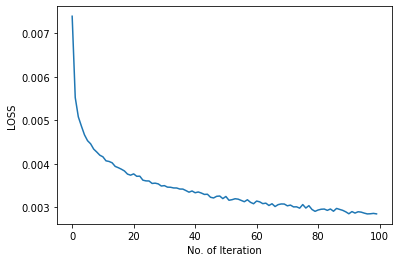

In [12]:
plt.plot(total_train_loss)
plt.xlabel("No. of Iteration")
plt.ylabel("LOSS")
plt.show

# Confusion Matrix for Train-Set

In [13]:
from sklearn.metrics import confusion_matrix , classification_report

y_pred = model(train_x)
train_pred = (nn.functional.softmax(y_pred, dim = 1)).argmax(1)
print(confusion_matrix(train_y.T, train_pred.T))

[[5527   11   61  129    7    7  224    6   25    3]
 [   9 5878    7   76   10    1    3    6    4    6]
 [ 104    6 5171   53  416    6  216    7   16    5]
 [ 109   28   14 5634  140    7   43    8   10    7]
 [   9    5  418  204 5123    2  208    2   24    5]
 [   1    0    0    2    0 5815    0  114    4   64]
 [1004   10  420  137  322    8 4059    1   34    5]
 [   0    1    0    0    0   12    0 5866    9  112]
 [  27    4    5   26    8   17   15   13 5874   11]
 [   0    0    0    3    0    7    0  219    0 5771]]


In [14]:
print(classification_report(train_y.T, train_pred.T))

              precision    recall  f1-score   support

           0       0.81      0.92      0.86      6000
           1       0.99      0.98      0.98      6000
           2       0.85      0.86      0.85      6000
           3       0.90      0.94      0.92      6000
           4       0.85      0.85      0.85      6000
           5       0.99      0.97      0.98      6000
           6       0.85      0.68      0.75      6000
           7       0.94      0.98      0.96      6000
           8       0.98      0.98      0.98      6000
           9       0.96      0.96      0.96      6000

    accuracy                           0.91     60000
   macro avg       0.91      0.91      0.91     60000
weighted avg       0.91      0.91      0.91     60000



<AxesSubplot:>

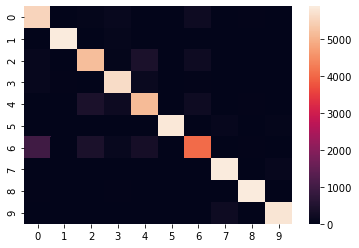

In [15]:
sns.heatmap(confusion_matrix(train_y.T, train_pred.T))

# Confusion Matrix for Train-Set

In [16]:
y_pred = model(test_x)
test_pred = (nn.functional.softmax(y_pred, dim = 1)).argmax(1)
print(confusion_matrix(test_y.T, test_pred.T))

[[876   2  14  20   1   6  71   2   7   1]
 [  5 981   0   9   2   1   0   1   1   0]
 [ 28   1 801  21  81   2  56   1   7   2]
 [ 33  10   7 909  21   4   9   2   4   1]
 [  2   2  81  38 820   5  47   0   4   1]
 [  0   1   1   1   0 925   2  41   3  26]
 [199   3  82  35  77   2 590   0  12   0]
 [  0   0   0   0   0  10   0 950   0  40]
 [  6   1   5   4   4   4   7   4 960   5]
 [  0   0   0   0   0   5   0  60   0 935]]


In [17]:
print(classification_report(test_y.T, test_pred.T))

              precision    recall  f1-score   support

           0       0.76      0.88      0.82      1000
           1       0.98      0.98      0.98      1000
           2       0.81      0.80      0.80      1000
           3       0.88      0.91      0.89      1000
           4       0.82      0.82      0.82      1000
           5       0.96      0.93      0.94      1000
           6       0.75      0.59      0.66      1000
           7       0.90      0.95      0.92      1000
           8       0.96      0.96      0.96      1000
           9       0.92      0.94      0.93      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



<AxesSubplot:>

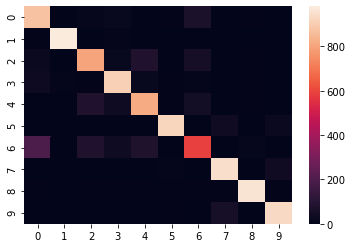

In [18]:
sns.heatmap(confusion_matrix(test_y.T, test_pred.T))